# One Shot Learning Implementation - using Affine Transformations

![](./Output/omniglot_grid_cropped.jpg)

For a neural network to learn features from images in order to classify them we need data, lots of data. It is difficult for a model to learn from very few samples per class. 

MNIST dataset has nearly 60000 training images for numbers 0–9 (10 classes). 

We will implement One shot learning to build a model which will correctly make predictions given only a single example of each new class.

## Importing Dependencies

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import pickle as pkl
import cv2

from load_data import datainfo

from tqdm import tqdm
from math import ceil

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.transform import rotate, AffineTransform, warp

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Lambda, Input, Flatten, Dense, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, TruncatedNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam 
import tensorflow.keras.backend as K

### Seeding Random number generators

In [2]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

train_pkl = "./train_data.pkl"


In [3]:
def pkl_data(filename):
    with open(filename,'rb') as f:
        X_t, y_t = pkl.load(f)
    return X_t, y_t

## Visualize Alphabet and Character Data

In [4]:
X_t, y_t = pkl_data('test_dir_data.pkl')

In [48]:
assert(len(X_t) == len(y_t)),"X_t and Y_t are of different sizes"
print(len(X_t))

13180


In [6]:
print(X_t.shape)

(13180, 1)


In [49]:
def visualize_alphabets(alphabet= None, character = False, n = 20):
    labels = np.unique(y_t)
    labels = [label for label in labels if alphabet in str(label)]
    label_to_idx = [np.where(y_t==label)[0] for label in labels]
    img_matrix = []
    X_p = []
    for i in tqdm(range(1,n+1)):
        if character == False:
            label_ids = label_to_idx[i-1]
            id1 = random.choice(label_ids)
        else:
            id1 = label_to_idx[0][i-1]
        
        img0_path = X_t[id1][0]
        img0 = mpimg.imread(img0_path)
        X_p.append(img0)
        if i%4==0:
            X_p =np.vstack(X_p)
            img_matrix.append(X_p)
            X_p = []
    img_matrix = np.asarray(img_matrix)
    img_matrix = np.hstack(img_matrix)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img_matrix, cmap = 'gray')
    plt.title(alphabet)

100%|██████████| 20/20 [00:00<00:00, 2506.61it/s]


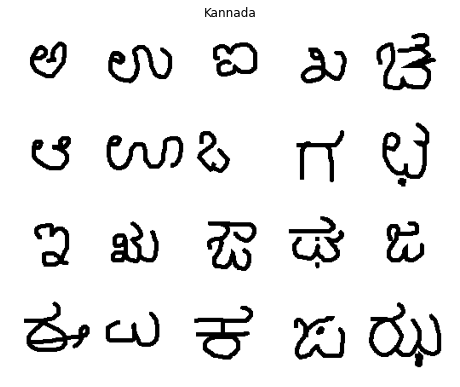

In [50]:
alphabet = 'Kannada'
visualize_alphabets(alphabet, n = 20)       

100%|██████████| 20/20 [00:00<00:00, 2506.68it/s]


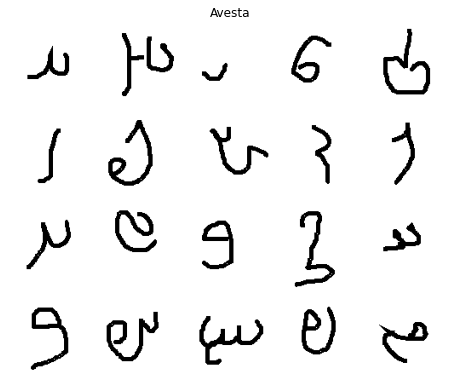

In [51]:
alphabet = 'Avesta'
visualize_alphabets(alphabet, n = 20) 

100%|██████████| 20/20 [00:00<00:00, 2506.61it/s]


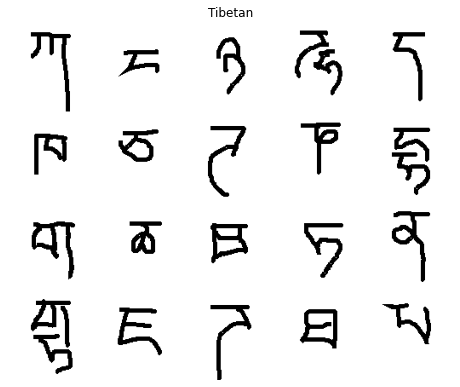

In [52]:
alphabet = 'Tibetan'
visualize_alphabets(alphabet, n = 20) 

### Same characters drawn by different people

100%|██████████| 20/20 [00:00<00:00, 2227.64it/s]


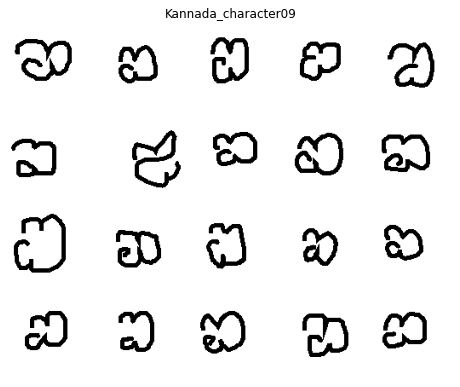

In [55]:
alphabet = 'Kannada_character09'
visualize_alphabets(alphabet =alphabet, character = True, n = 20) 

100%|██████████| 20/20 [00:00<00:00, 2228.11it/s]


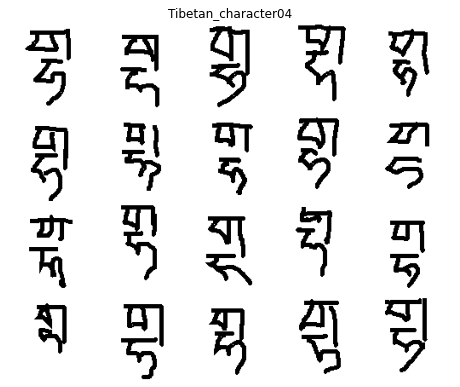

In [56]:
alphabet = 'Tibetan_character04'
visualize_alphabets(alphabet =alphabet, character = True, n = 20) 

## Load Training Data

In [24]:
X_t, y_t = pkl_data(train_pkl)

In [25]:
X_train, X_valid, y_train, y_valid=train_test_split(X_t, y_t,test_size=0.2,random_state=7)

## Image Augmentation - scaling, rotation

In [26]:
def affinetransform(image):
    transform = AffineTransform(translation=(-30,0))
    warp_image = warp(image,transform, mode="wrap")
    return warp_image

def anticlockwise_rotation(image):
    angle= random.randint(0,45)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,45)
    return rotate(image, -angle)


In [27]:
def transform(image):
    if random.random() > 0.5:
        image = affinetransform(image)
    if random.random() > 0.5:
        image = anticlockwise_rotation(image)
    if random.random() > 0.5:
        image = clockwise_rotation(image)
    return image

## Performing Image Augmentation and Data generation at runtime

In [28]:
def data_generator(X_t, y_t,batch_size, isTrain = True):
    num_samples = len(X_t)
    while(True):
        for offset in range(0, num_samples, batch_size):
            x = X_t[offset:offset + batch_size]
            y = y_t[offset:offset + batch_size]
            
            X_left, X_right, y_batch = [],[],[]

            for i in range(len(x)):
                img0_path, img1_path = x[i][0], x[i][1]
                label = y[i] 
                img0 = mpimg.imread(img0_path)
                img1 = mpimg.imread(img1_path)

                if isTrain:
                    img0 = transform(img0)
                    img1 = transform(img1)
                
                img0 = np.expand_dims(img0, axis = 2)
                img1 = np.expand_dims(img1, axis = 2)

                
                X_left.append(img0)
                X_right.append(img1)
                y_batch.append(label)

            X_left, X_right, y_batch = np.array(X_left), np.array(X_right), np.array(y_batch)
            yield [X_left, X_right], y_batch

In [29]:
batch_size = 32

train_generator = data_generator(X_train,y_train, batch_size= batch_size, isTrain=True)
valid_generator = data_generator(X_valid, y_valid, batch_size = batch_size, isTrain=False)

Text(0.5, 1.0, '[1]')

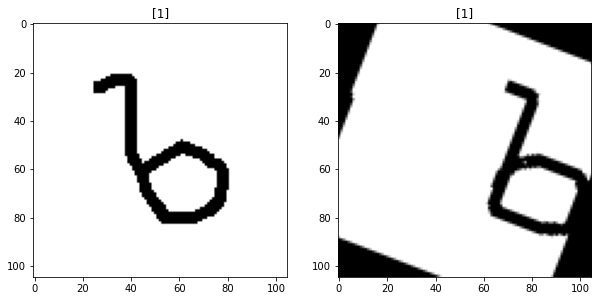

In [31]:
X_o, y_t = next(train_generator)
X_left, X_right = X_o[0], X_o[1]
for i in range(len(y_t)):
    if y_t[i] == 1:
        break

img0 = X_left[i]
img1 = X_right[i]
label = y_t[i]

img0 = np.squeeze(img0, axis = 2)
img1 = np.squeeze(img1, axis = 2)

f, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(img0,cmap = 'gray')
ax[0].set_title(label)

ax[1].imshow(img1, cmap = 'gray')
ax[1].set_title(label)

Text(0.5, 1.0, '[0]')

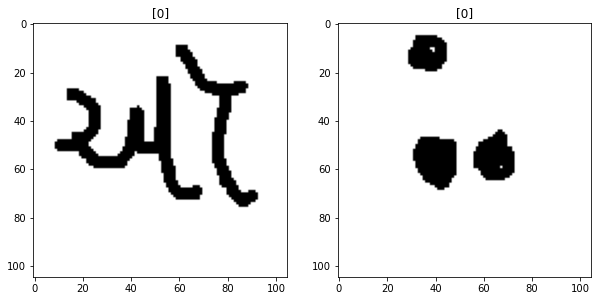

In [32]:
X_o, y_t = next(valid_generator)
X_left, X_right = X_o[0], X_o[1]
for i in range(len(y_t)):
    if y_t[i] == 0:
        break

img0 = X_left[i]
img1 = X_right[i]
label = y_t[i]

img0 = np.squeeze(img0, axis = 2)
img1 = np.squeeze(img1, axis = 2)

f, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(img0,cmap = 'gray')
ax[0].set_title(label)

ax[1].imshow(img1, cmap = 'gray')
ax[1].set_title(label)

In [33]:
batch_size = 32

train_generator = data_generator(X_train,y_train, batch_size= batch_size, isTrain=True)
valid_generator = data_generator(X_valid, y_valid, batch_size = batch_size, isTrain=False)

In [4]:
def plot_metric(history):
    acc, val_acc, loss, val_loss = history['accuracy'], history['val_accuracy'], history['loss'], history['val_loss']
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc = "upper left")

    plt.subplot(1,2,2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc = "upper left")

In [5]:
def euclidean_dist(vect):
    x, y = vect
    sum_square = K.sum(K.square(x-y), axis = 1, keepdims = True)
    result = K.maximum(sum_square, K.epsilon())
    return result

## Siamese Network Architecture

![](./Output/siamese_Net.jpg)


In [6]:
def get_model():

    input_shape = (105, 105, 1)
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    convnet = Sequential()
    convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(7,7),activation='relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(128,(4,4),activation='relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(256,(4,4),activation='relu'))
    convnet.add(Flatten())
    convnet.add(Dense(4096,activation="sigmoid"))
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)

    merge_layer = Lambda(euclidean_dist)([encoded_l,encoded_r])
    prediction = Dense(1,activation='sigmoid')(merge_layer)
    model = Model(inputs=[left_input,right_input],outputs=prediction)

    model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr =0.00006), metrics = ['accuracy'])
    return model


In [7]:
siamese_net = get_model()
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [38]:
siamese_net.count_params()

38947650

In [20]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
history = siamese_net.fit(train_generator, steps_per_epoch=ceil(len(X_train)/batch_size),
                             validation_data = valid_generator, validation_steps = ceil(len(X_valid)/batch_size), epochs = 20, verbose = True, shuffle = True, callbacks=callbacks_list)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9158/9158 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.7356WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001920DD9A948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

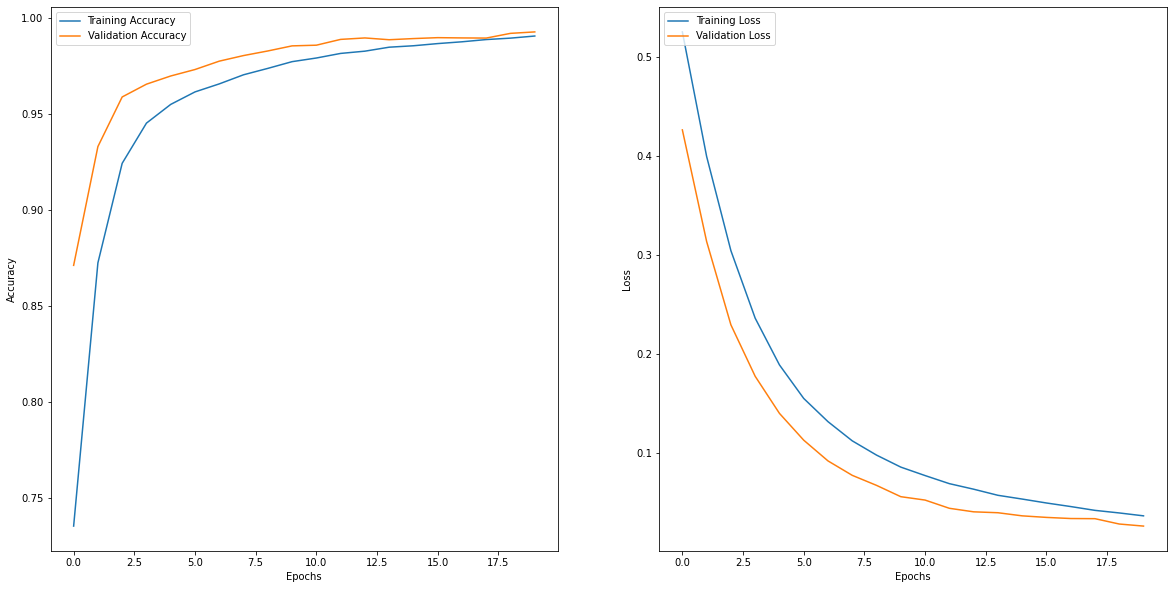

In [22]:
plot_metric(history.history)

## Testing with all pairs of images in Evaluation set

In [59]:
X_t, y_t = pkl_data('test_data.pkl')

In [60]:
#X_t, y_t = pkl_data('test_dir_data.pkl')
test_generator = data_generator(X_t,y_t, batch_size= 1024)

In [8]:
siamese_net.load_weights('weights-improvement-20-0.99.hdf5')

In [62]:
total_batches = ceil(len(X_t)/1024)
print(total_batches)
result = 0
for i in range(total_batches):
    x_o, y_o = next(test_generator)
    result += siamese_net.evaluate(x_o, y_o, batch_size =1024)[1]
result /= total_batches

#result = siamese_net.evaluate(test_generator, batch_size = 128)


- 0s 0s/step - loss: 0.2627 - accuracy: 0.8994
1/1 [==============================] - 0s 997us/step - loss: 0.6371 - accuracy: 0.8617


In [63]:
print('Evaluation Accuracy: {:.2f} %'.format(result*100))

Evaluation Accuracy: 93.57 %


## N way One shot Testing

In order to evaluate this model, we will perform N-way one shot classification. Here N implies how many images will be there in the support set .

Say, there is 1 image for evaluation, N images of different class in support set, and exactly one image is from the same class as the test image for evaluation. 

Model should predict high probability  for the pair of images which belong to same class and low probability to remaining N-1 pairs.

Note : To test N-way one shot , instead of testing all possible pairs for each N [[2, 5, 6, 10, 15, 16, 20]] I sampled support set for all classes randomly. 


In [9]:
X_t, y_t = pkl_data('test_dir_data.pkl')

In [10]:
def test_one_shot(model,X_left,X_right):
    prob = model.predict([X_left,X_right])
    if np.argmax(prob) == 0:
        return 1
    else:
        return 0

In [168]:
def load_test_batch(n_samples):
    
    correct_pred = 0
    labels = np.unique(y_t)
    label_to_idx = [np.where(y_t==label)[0] for label in labels]
    for i in tqdm(range(len(labels))):

        X_left, X_right =[],[]
        y=[]

        lbl1 = i
        label_ids = label_to_idx[i]

        #same
        id1 = random.choice(label_ids)
        id2 = random.choice(label_ids)
        img0_path = X_t[id1][0]
        img1_path = X_t[id2][0]

        img0 = mpimg.imread(img0_path)
        img1 = mpimg.imread(img1_path)

        img0 = np.expand_dims(img0, axis = 2)
        img1 = np.expand_dims(img1, axis = 2)

        X_left.append(img0)
        X_right.append(img1)
        #y.append(1)

        for _ in range(n_samples):

            lbl2 = random.randint(0, len(labels)-1)
            while(lbl2 == lbl1):
                lbl2 = random.randint(0, len(labels)-1)
            id = random.choice(label_to_idx[lbl2])
            img2_path = X_t[id][0]
            img2 = mpimg.imread(img2_path)
            img2 = np.expand_dims(img2, axis = 2)

            X_left.append(img0)
            X_right.append(img2)
            
            #y.append(0)
        X_left, X_right = np.array(X_left), np.array(X_right)

        correct_pred += test_one_shot(siamese_net,X_left, X_right)
    return correct_pred*100/i

        

In [169]:
def one_shot_accuracy(k = 5, n_way = [1, 4, 5, 9, 14, 15, 19]):
    accuracies = []
    #[2, 5, 6, 10, 15, 16, 20]
    for i in n_way:
        avg_acc = []
        for _ in range(k):
            avg_acc.append(load_test_batch(i))
        accuracies.append(np.mean(avg_acc))
    return accuracies, [i+1 for i in n_way]


In [170]:
# Performing N way one shot averaged over 5 iterations for entire set of classes
accuracies, n_way  = one_shot_accuracy()

100%|██████████| 659/659 [00:28<00:00, 23.15it/s]


In [171]:
for i, acc in zip(n_way, accuracies):
    print('Accuracy of {}-way one shot learning: {:.2f} %'.format(i, acc))

Accuracy of 2-way one shot learning: 98.78 %
Accuracy of 5-way one shot learning: 96.75 %
Accuracy of 6-way one shot learning: 96.75 %
Accuracy of 10-way one shot learning: 94.22 %
Accuracy of 15-way one shot learning: 91.79 %
Accuracy of 16-way one shot learning: 91.61 %
Accuracy of 20-way one shot learning: 90.43 %


## Visualizing Support set and predictions

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
import re

In [12]:
def visualize_20_way(n_samples):
    labels = np.unique(y_t)
    label_to_idx = [np.where(y_t==label)[0] for label in labels]
    X_left, X_right =[],[]
    X_p = []
    img_matrix = []
    lbl1 = random.choice(range(len(labels)))
    label_ids = label_to_idx[lbl1]

    id1 = random.choice(label_ids)
    id2 = random.choice(label_ids)
    img0_path = X_t[id1][0]
    img1_path = X_t[id2][0]

    img0 = mpimg.imread(img0_path)
    img1 = mpimg.imread(img1_path)
    X_p.append(img1)

    img0 = np.expand_dims(img0, axis = 2)
    img1 = np.expand_dims(img1, axis = 2)
    X_left.append(img0)
    X_right.append(img1)
    for _ in range(n_samples-1):

        lbl2 = random.randint(0, len(labels)-1)
        while(lbl2 == lbl1):
            lbl2 = random.randint(0, len(labels)-1)
        id = random.choice(label_to_idx[lbl2])
        img2_path = X_t[id][0]
        img2 = mpimg.imread(img2_path)
        X_p.append(img2)
        img2 = np.expand_dims(img2, axis = 2)
        X_left.append(img0)
        X_right.append(img2)
        if len(X_p) == 5:
            X_p =np.vstack(X_p)
            img_matrix.append(X_p)
            X_p = []

    img_matrix = np.asarray(img_matrix)
    img_matrix = np.hstack(img_matrix)

    X_left, X_right = np.array(X_left), np.array(X_right)
    prob = siamese_net.predict([X_left,X_right])
    index = np.argmax(prob)
    return img0, img_matrix, index, X_right

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Text(0.5, 1.0, 'Image with highest similarity in Support Set')

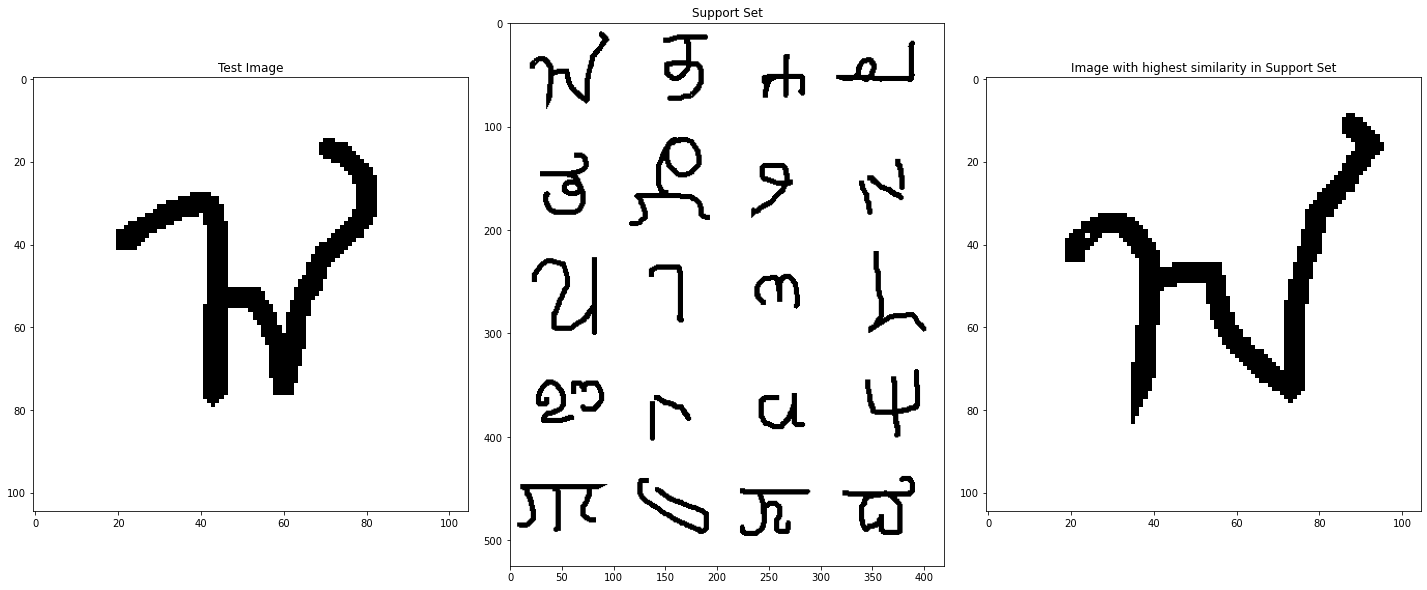

In [13]:
n_samples = 20
img0, img_matrix, index, X_right = visualize_20_way(n_samples)

f, ax=  plt.subplots(1,3, figsize = (20,20))
f.tight_layout()
ax[0].imshow(np.squeeze(img0, axis = 2), cmap = 'gray')
ax[0].set_title('Test Image')
ax[1].imshow(img_matrix, cmap = 'gray')
ax[1].set_title('Support Set')
ax[2].imshow(np.squeeze(X_right[index], axis = 2), cmap = 'gray')
ax[2].set_title('Image with highest similarity in Support Set')